Plots a histogram to visually communicate temperature anomaly of a day's SST

In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.colors as mcolors

In [68]:
def suffix(day):
    updated_day = day
    if updated_day == 1:
        suffix = 'st'
    elif updated_day == 2:
        suffix = 'nd'
    elif updated_day == 3:
        suffix = 'rd'
    elif (4 <= updated_day <= 20):
        suffix = 'th'
    elif updated_day == 21:
        suffix = 'st'
    elif updated_day == 22:
        suffix = 'nd'
    elif updated_day == 23:
        suffix = 'rd'
    elif (24 <= updated_day <= 30):
        suffix = 'th'
    elif updated_day == 31:
        suffix = 'st'
    return suffix

In [69]:
months = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

In [70]:
c_to_f = lambda c: (c*(9/5)) + 32

In [71]:
def trivia_msg(climatology, today_sst, day, month):
    trivia_msg = None
    obs_datetime = datetime(year=int(2024), month=int(month), day=int(day)).strftime('%b %-d, %Y')
    if today_sst > climatology.SURF_TEMP_C.mean():
        trivia_msg = obs_datetime + ' is warmer than the average of all ' + months[month] + ' ' + str(int(day)) + suffix(day) + 's.'
    elif today_sst < climatology.SURF_TEMP_C.mean():
        trivia_msg = obs_datetime + ' is cooler than the average of all ' + months[month] + ' ' + str(int(day)) + suffix(day) + 's.'
    if today_sst > np.nanpercentile(climatology.SURF_TEMP_C.values,90): #How do you define a MHW day? Also np.percentile assumes a normal distribution I think
        trivia_msg = obs_datetime + ' is among the hottest 10% of ' + months[month] + ' ' + str(int(day)) + suffix(day) + 's on record.'
    if today_sst < np.nanpercentile(climatology.SURF_TEMP_C.values,10): #How do you define a MHW day? Also np.percentile assumes a normal distribution I think
        trivia_msg = obs_datetime + ' is among the coldest 10% of ' + months[month] + ' ' + str(int(day)) + suffix(day) + 's on record.'
    if today_sst >= climatology.SURF_TEMP_C.max():
        trivia_msg = obs_datetime + ' is the hottest ' + months[month] + ' ' + str(int(day)) + suffix(day) + ' on record.'
    elif today_sst <= climatology.SURF_TEMP_C.min():
        trivia_msg = obs_datetime + ' is the coldest ' + months[month] + ' ' + str(int(day)) + suffix(day) + ' on record.'
    return trivia_msg

In [72]:
from pathlib import Path
import matplotlib as mpl
fpath = Path(mpl.get_data_path(), "/Users/noahbarton/Library/CloudStorage/OneDrive-UCSanDiego/sccoos/sst_hist/lato/Lato-Regular.ttf")

In [73]:
def sst_hist(sst_filename, location):
    bottom = (location == 'SIO Pier Bottom')
    usecols = ['SURF_TEMP_C','MONTH','DAY','YEAR'] if ~bottom else ['BOT_TEMP_C','MONTH','DAY','YEAR']
    all_sst = pd.read_csv(sst_filename, usecols=usecols)
    last = all_sst.iloc[-1,:] #TODO make sure years match between obs and title
    day = int(last.DAY)
    month = int(last.MONTH)
    year = int(last.YEAR)
    today = datetime(year,month,day)
    if ~bottom: today_sst = last.SURF_TEMP_C
    elif bottom: today_sst = last.BOT_TEMP_C
    today_sst_f = str(round(c_to_f(today_sst), 1))
    today_suffix = suffix(day)
    
    climatology = all_sst[(all_sst['MONTH'] == month) & (all_sst['DAY'] == day)]
    if ~bottom:
        max_day = all_sst.loc[climatology.SURF_TEMP_C.idxmax()]
        hottest = climatology.SURF_TEMP_C.max()
        min_day = all_sst.loc[climatology.SURF_TEMP_C.idxmin()]
        mean = climatology.SURF_TEMP_C.mean()
        coldest = climatology.SURF_TEMP_C.min()
    elif bottom:
        max_day = all_sst.loc[climatology.BOT_TEMP_C.idxmax()]
        hottest = climatology.BOT_TEMP_C.max()
        min_day = all_sst.loc[climatology.BOT_TEMP_C.idxmin()]
        mean = climatology.BOT_TEMP_C.mean()
        coldest = climatology.BOT_TEMP_C.min()
    n = str(len(climatology))


    title = 'How does '+datetime.strftime(today,'%B %-d, %Y')+' compare to other years?'
    subtitle = datetime.strftime(today,'%B %-d') + ' records: '
    max_msg = 'Daily High SST: '  + str(hottest) + '°C/'+str(round(c_to_f(hottest), 1))+'°F in ' + str(int(max_day.YEAR))
    min_msg = 'Daily Low SST: '  + str(coldest) + '°C/'+str(round(c_to_f(coldest), 1))+'°F in ' + str(int(min_day.YEAR))
    mean_msg = 'Average SST: ' + str(round(mean,1)) + '°C/' + today_sst_f +'°F\n\
from ' + n + ' samples since ' + str(climatology.YEAR.min())
    comparison_msg = trivia_msg(climatology, today_sst, day, month)
    
    today_label_y = today_sst + 0.2 if today_sst > mean else today_sst - 0.2
    today_label_va = 'bottom' if today_sst > mean else 'top'
    mean_label_y = mean + 0.2 if today_sst < mean else mean - 0.2
    mean_label_va = 'top' if today_label_va == 'bottom' else 'bottom'
    today_label = "Today's Temperature: " + str(today_sst) + '°C/' + str(round(c_to_f(today_sst), 1)) +'°F'
    avg_label = "Average Temperature for " + today.strftime('%b %-d') + today_suffix
    #avg_label = today.strftime('%b %-d') + ' Average Temperature (' + n + ' years')
    if ~bottom:
        hist, bin_edges = np.histogram(climatology.SURF_TEMP_C, bins=np.arange(coldest // 1, hottest // 1 + 1,1))
    elif bottom:
        hist, bin_edges = np.histogram(climatology.BOT_TEMP_C, bins=np.arange(coldest // 1, hottest // 1 + 1,1)) 
    bar_width = bin_edges[1] - bin_edges[0]

    fig, ax = plt.subplots()
    cmap = plt.colormaps.get_cmap('RdBu_r')
    for i in range(len(bin_edges) - 1):
        color = cmap((bin_edges[i] - coldest) / (hottest - coldest))
        ax.barh(bin_edges[i], hist[i], height=bar_width, align='center', color=color)
    ax.axhline(y=mean, color='#404040', linestyle='dotted', linewidth=1)
    ax.axhline(y=today_sst, color='k', linestyle='dashed', linewidth=1)
    ax.text(0.1, today_label_y, today_label, font=fpath, va=today_label_va)
    ax.text(0.1, mean_label_y, avg_label, c='#404040', font=fpath, va=mean_label_va)

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().set_visible(False)
    if ~bottom: ax.set_ylabel('Sea Surface Temperature (°C)')
    if bottom: ax.set_ylabel('Sea Botttom Temperature (°C)')

    ax.text(0, -0.05, subtitle, transform=ax.transAxes, va='top', font=fpath)
    ax.text(0,-0.1, max_msg, transform=ax.transAxes, va='top', color='#a50f15', font=fpath)
    ax.text(0,-0.15, min_msg, transform=ax.transAxes, va='top', color='#08519c', font=fpath)
    ax.text(0,-0.2, mean_msg, transform=ax.transAxes, va='top', font=fpath)
    ax.text(0, 1.17, title, transform=ax.transAxes, va='top', font=fpath, fontsize=18)
    comparison_color = '#a50f15' if today_sst > mean else '#08519c'
    ax.text(0, 1.1, comparison_msg, transform=ax.transAxes, va='top', font=fpath, color = comparison_color, fontsize=14)
    filenames = {'SIO Pier Surface': 'sio_surface_hist',
                 'SIO Pier Bottom': 'sio_bottom_hist',
                 'Zuma Beach': 'zuma_hist'}
    
    fig_filename = filenames[location]+".png"
    fig_dir = 'fig'
    plt.savefig(fig_dir+'/'+fig_filename, dpi=500, bbox_inches='tight')
    plt.show()

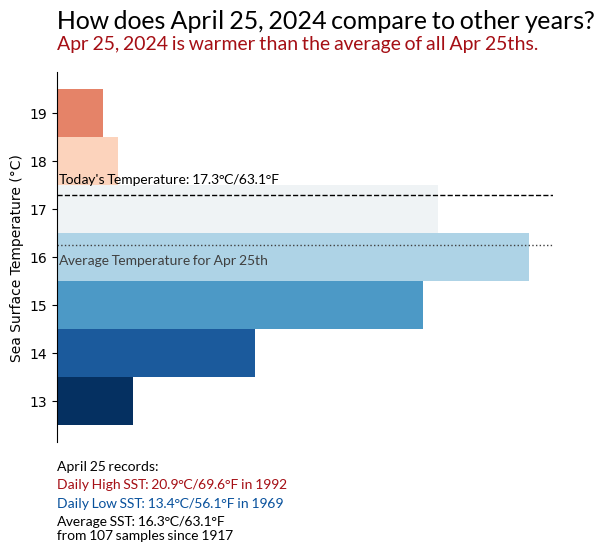

In [74]:
sst_filename="/Users/noahbarton/Library/CloudStorage/OneDrive-UCSanDiego/sccoos/data/non-QC'd SIO Shore Station Data.csv"
location = 'SIO Pier Surface'

sst_hist(sst_filename, location)

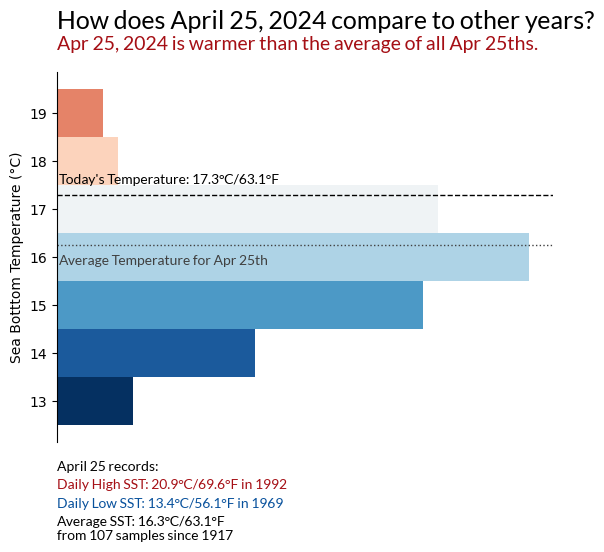

In [75]:
sst_filename="/Users/noahbarton/Library/CloudStorage/OneDrive-UCSanDiego/sccoos/data/non-QC'd SIO Shore Station Data.csv"
location = 'SIO Pier Bottom'

sst_hist(sst_filename, location)

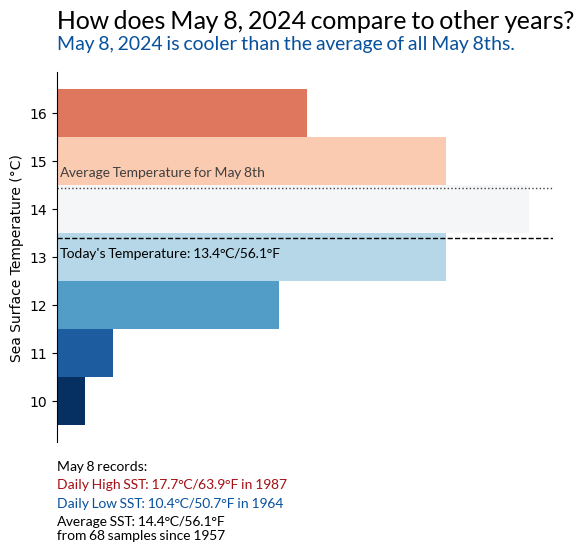

In [78]:
sst_filename="/Users/noahbarton/Library/CloudStorage/OneDrive-UCSanDiego/sccoos/data/non-QC'd Zuma Beach Shore Station Data.csv"
location = 'Zuma Beach'

sst_hist(sst_filename, location)

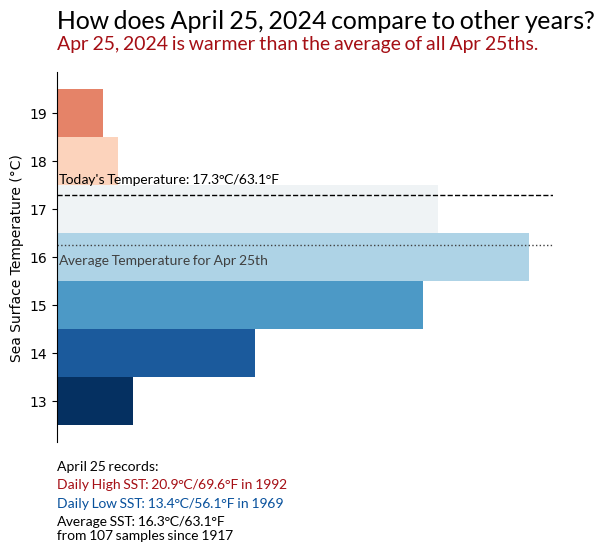

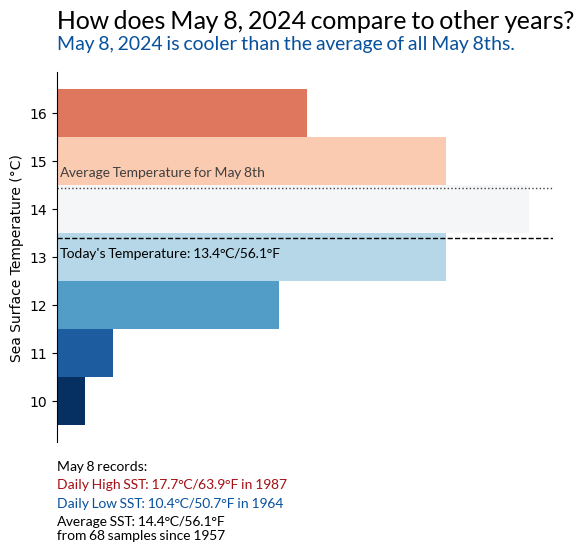

In [80]:
info = (("/Users/noahbarton/Library/CloudStorage/OneDrive-UCSanDiego/sccoos/data/non-QC'd SIO Shore Station Data.csv", 'SIO Pier Surface'),
        ("/Users/noahbarton/Library/CloudStorage/OneDrive-UCSanDiego/sccoos/data/non-QC'd Zuma Beach Shore Station Data.csv", 'Zuma Beach'))

for station in info:
    sst_hist(station[0], station[1])